# Toy problem to describe windowing effects on strain rate

Strain is given by the change in depth of a reflector over its original depth. Strain rate is then the change in time of strain, and is therefore equivalent to the vertical velocity over the original depth. Consequently, for a single reflector, who's original depth does not change in time, its evolution in strain rate over time is proportional to its vertical velocity. We will therefore use this single reflector and its relative position as the foundation of our toy problem. By calculating the temporal derivative of its relative position, we obtain a velocity, which will be our strain rate analogue. Below are some examples.

In [1]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import matplotlib.pyplot as plt

Text(0.5, 0, 't [days]')

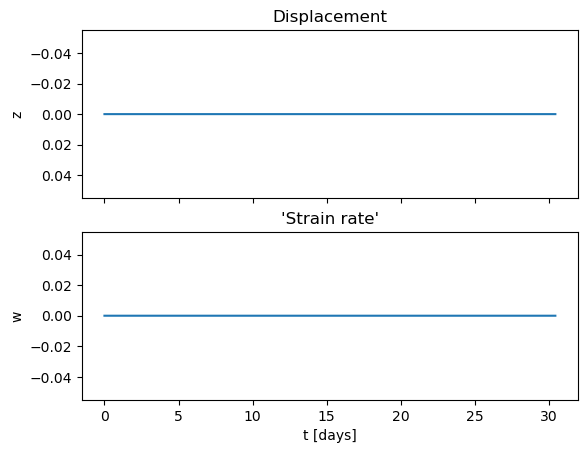

In [2]:
# No displacement
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements)
ax[0].set_title('Displacement')
ax[0].set_ylabel('z')
ax[0].invert_yaxis()
strain_true = np.gradient(displacements)/np.gradient(time)
ax[1].plot(time/86400,strain_true)
ax[1].set_title("'Strain rate'")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')

For a unchanging reflector, the result is as expected, there is no change in strain. Now let's do a linearlly changing reflector, having it move farther from the sensor

(0.0, 0.1)

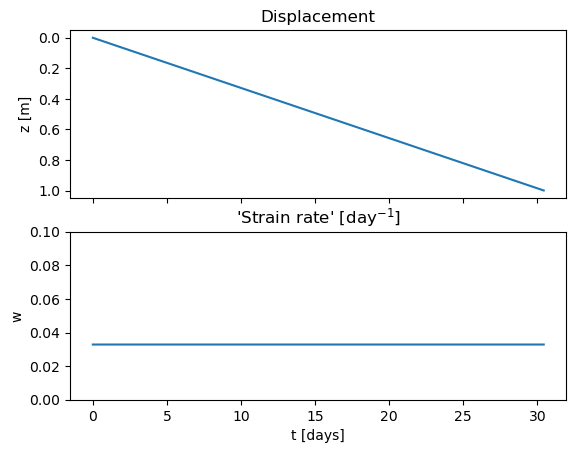

In [3]:
# Linear displacement
time = np.arange(0, 2629800,900)
displacements = np.arange(0, 2629800,900)/2629800
fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements)
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400
ax[1].plot(time/86400,strain_true)
ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
ax[1].set_ylim([0,0.1])

Here, we have a constant strain rate. Now, we introduce our two methods to compare to the true strain rate. Our first method involves calculating the displacement between each burst (through the coherence method described by Stewart), and then summing across a larger window to get a stronger signal to determine a velocity from. It is implemented here. Let's say in our case, the samples are made once every day. We sum every 3 days to get a total displacement.

In [4]:
def strain_rate_sum(sample_times,sample,window):
    sum_disp = sliding_window_view(np.diff(sample),window_shape=window)[::window].sum(axis=1)
    sum_time = sliding_window_view(np.diff(sample_times),window_shape=window)[::window].sum(axis=1)
    ret_mean_time = sliding_window_view(sample_times,window_shape=window)[::window].mean(axis=1)
    return ret_mean_time,sum_disp/sum_time

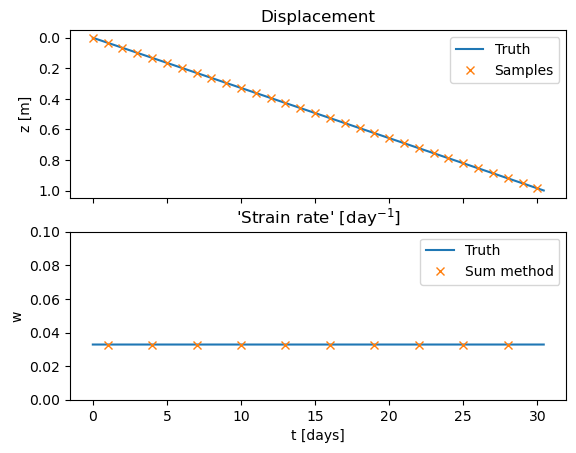

In [5]:
# Linear displacement
time = np.arange(0, 2629800,900)
displacements = np.arange(0, 2629800,900)/2629800

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400

sum_time,sum_strain = strain_rate_sum(sample_times,sample_displacements,3)

ax[1].plot(time/86400,strain_true,label='Truth')
ax[1].plot(sum_time/86400,sum_strain* 86400,linestyle='None',marker='x',label = 'Sum method')

# Plot vertical lines showing window centers!

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
ax[1].set_ylim([0,0.1])
ax[1].legend()


For a linear strain rate, this method still works well. However, it reduces the temporal resolution. Also, even though it cannot be shown in this toy scenario, the summation method results in higher error compared to using the first and last burst of the window. This, and a want to preserve temporal resolution of strain rates, led to the adoption of a "leapfrog" method, discussed with Christian Wild. We still use a window of 3, meaning that they are a 3-day strain rate, but now the result is at the same temporal resolution as our samples

In [6]:
def strain_rate_leapfrog(sample_times,sample,window):
    vels = []
    vel_times = []
    for group, times in zip(sliding_window_view(sample,window_shape=window),sliding_window_view(sample_times,window_shape=window)):
        vels.append((group[-1]-group[0])/(times[-1]-times[0]))
        vel_times.append(times[0]+(times[-1]-times[0])/2)
    return np.asarray(vel_times),np.asarray(vels)

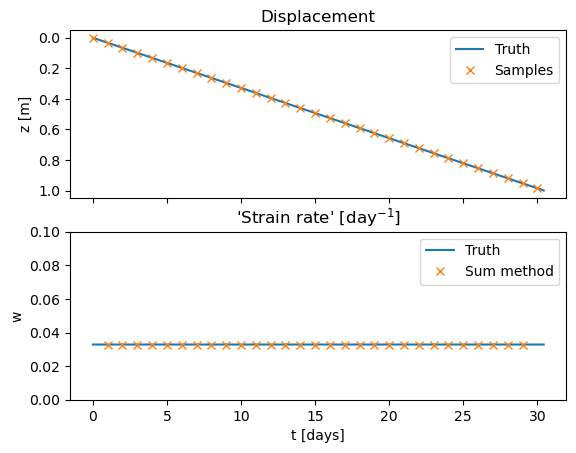

In [7]:
# Linear displacement
time = np.arange(0, 2629800,900)
displacements = np.arange(0, 2629800,900)/2629800

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400

sum_time,sum_strain = strain_rate_leapfrog(sample_times,sample_displacements,3)

ax[1].plot(time/86400,strain_true,label='Truth')
ax[1].plot(sum_time/86400,sum_strain* 86400,linestyle='None',marker='x',label = 'Sum method')

# Plot vertical lines showing window centers!

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
ax[1].set_ylim([0,0.1])
ax[1].legend()


Now we want to test this method against a signal more similar to that of the lake drainage.

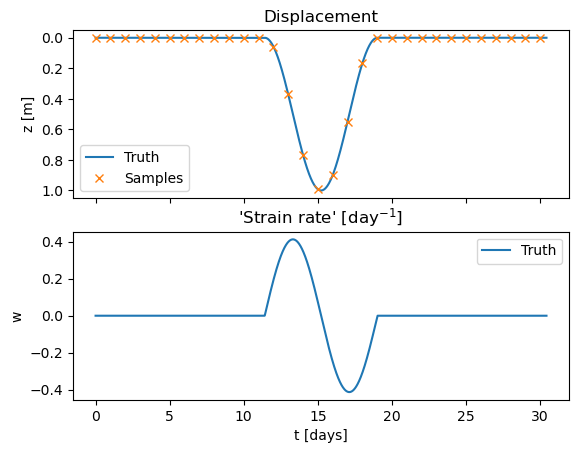

In [8]:
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
displacements[3*len(time)//8:5*len(time)//8] = (np.cos(4*np.pi*time[3*len(time)//8:5*len(time)//8]/2629800))**2

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400

ax[1].plot(time/86400,strain_true,label='Truth')

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
#ax[1].set_ylim([0,0.1])
ax[1].legend()


This signal corresponds with a meter of uplift and return to its original position over a ~8 day period. It's longer than the actual lake drainage but with our given sample rate, we only have ~7 samples detecting the displacement. This is a similar number of samples detecting the lake drainage.

Now we try different window sizes for our summation vs leapfrog methods. First, summation

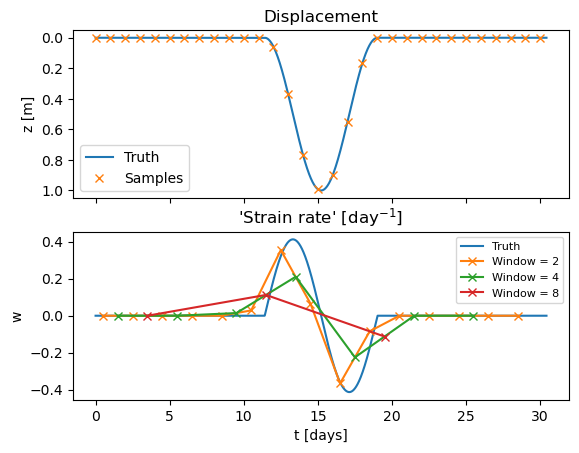

In [9]:
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
displacements[3*len(time)//8:5*len(time)//8] = (np.cos(4*np.pi*time[3*len(time)//8:5*len(time)//8]/2629800))**2

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400
ax[1].plot(time/86400,strain_true,label='Truth')
for window in [2,4,8]:
    sum_time,sum_strain = strain_rate_sum(sample_times,sample_displacements,window)

    ax[1].plot(sum_time/86400,sum_strain* 86400,marker='x',label = f'Window = {window}')

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
#ax[1].set_ylim([0,0.1])
ax[1].legend(loc='upper right',fontsize=8)


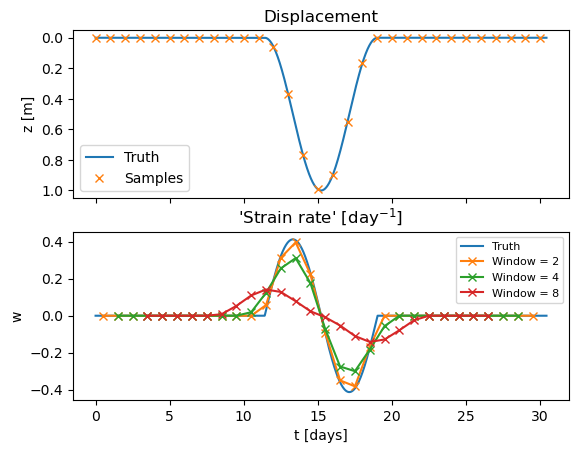

In [10]:
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
displacements[3*len(time)//8:5*len(time)//8] = (np.cos(4*np.pi*time[3*len(time)//8:5*len(time)//8]/2629800))**2

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400
ax[1].plot(time/86400,strain_true,label='Truth')
for window in [2,4,8]:
    sum_time,sum_strain = strain_rate_leapfrog(sample_times,sample_displacements,window)

    ax[1].plot(sum_time/86400,sum_strain* 86400,marker='x',label = f'Window = {window}')

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
#ax[1].set_ylim([0,0.1])
ax[1].legend(loc='upper right',fontsize=8)


Let's try narrowing this peak even more

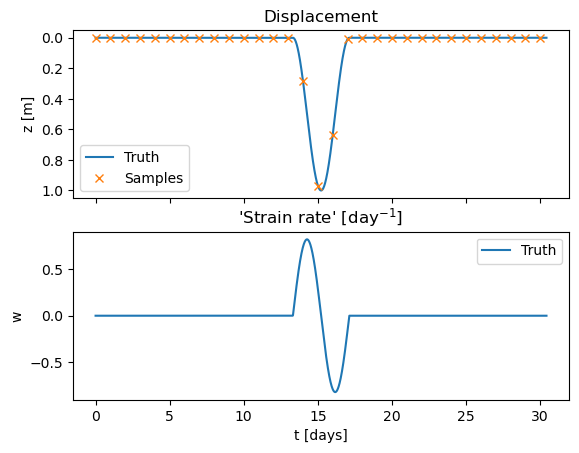

In [11]:
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
displacements[7*len(time)//16:9*len(time)//16] = (np.cos(8*np.pi*time[7*len(time)//16:9*len(time)//16]/2629800))**2

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400

ax[1].plot(time/86400,strain_true,label='Truth')

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
#ax[1].set_ylim([0,0.1])
ax[1].legend()


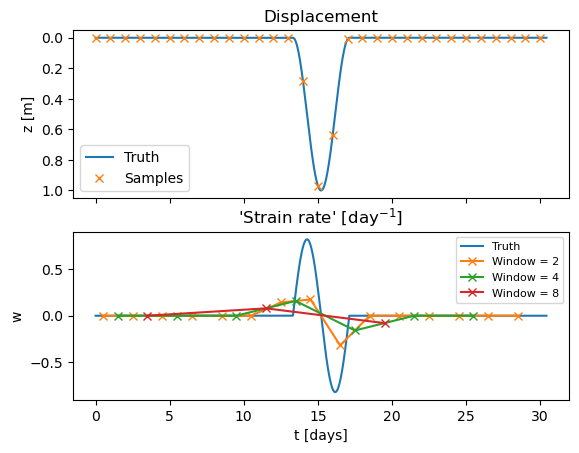

In [12]:
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
displacements[7*len(time)//16:9*len(time)//16] = (np.cos(8*np.pi*time[7*len(time)//16:9*len(time)//16]/2629800))**2

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400
ax[1].plot(time/86400,strain_true,label='Truth')
for window in [2,4,8]:
    sum_time,sum_strain = strain_rate_sum(sample_times,sample_displacements,window)

    ax[1].plot(sum_time/86400,sum_strain* 86400,marker='x',label = f'Window = {window}')

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
#ax[1].set_ylim([0,0.1])
ax[1].legend(loc='upper right',fontsize=8)


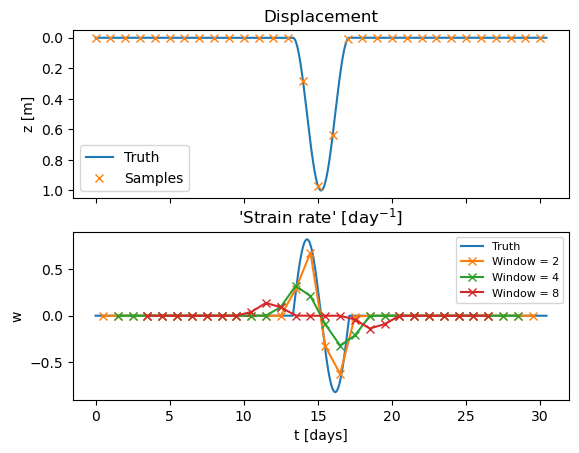

In [13]:
time = np.arange(0, 2629800,900)
displacements = np.zeros(time.shape)
displacements[7*len(time)//16:9*len(time)//16] = (np.cos(8*np.pi*time[7*len(time)//16:9*len(time)//16]/2629800))**2

sample_times = np.arange(0, 2629800,86400)
sample_displacements = np.interp(sample_times,time,displacements)

fig, ax = plt.subplots(nrows=2,sharex = True)
ax[0].plot(time/86400,displacements,label = 'Truth')
ax[0].plot(sample_times/86400,sample_displacements,linestyle='None',marker='x',label = 'Samples')
ax[0].set_title('Displacement')
ax[0].set_ylabel('z [m]')
ax[0].legend()
ax[0].invert_yaxis()

strain_true = np.gradient(displacements)/np.gradient(time) * 86400
ax[1].plot(time/86400,strain_true,label='Truth')
for window in [2,4,8]:
    sum_time,sum_strain = strain_rate_leapfrog(sample_times,sample_displacements,window)

    ax[1].plot(sum_time/86400,sum_strain* 86400,marker='x',label = f'Window = {window}')

ax[1].set_title("'Strain rate' [day$^{-1}$]")
ax[1].set_ylabel('w')
ax[1].set_xlabel('t [days]')
#ax[1].set_ylim([0,0.1])
ax[1].legend(loc='upper right',fontsize=8)


We see that with the leapfrog method, when the window size is larger than that of the event, we have this period of zero apparent strain rates between the positive and negative spike. This can be seen in our results, shown below.
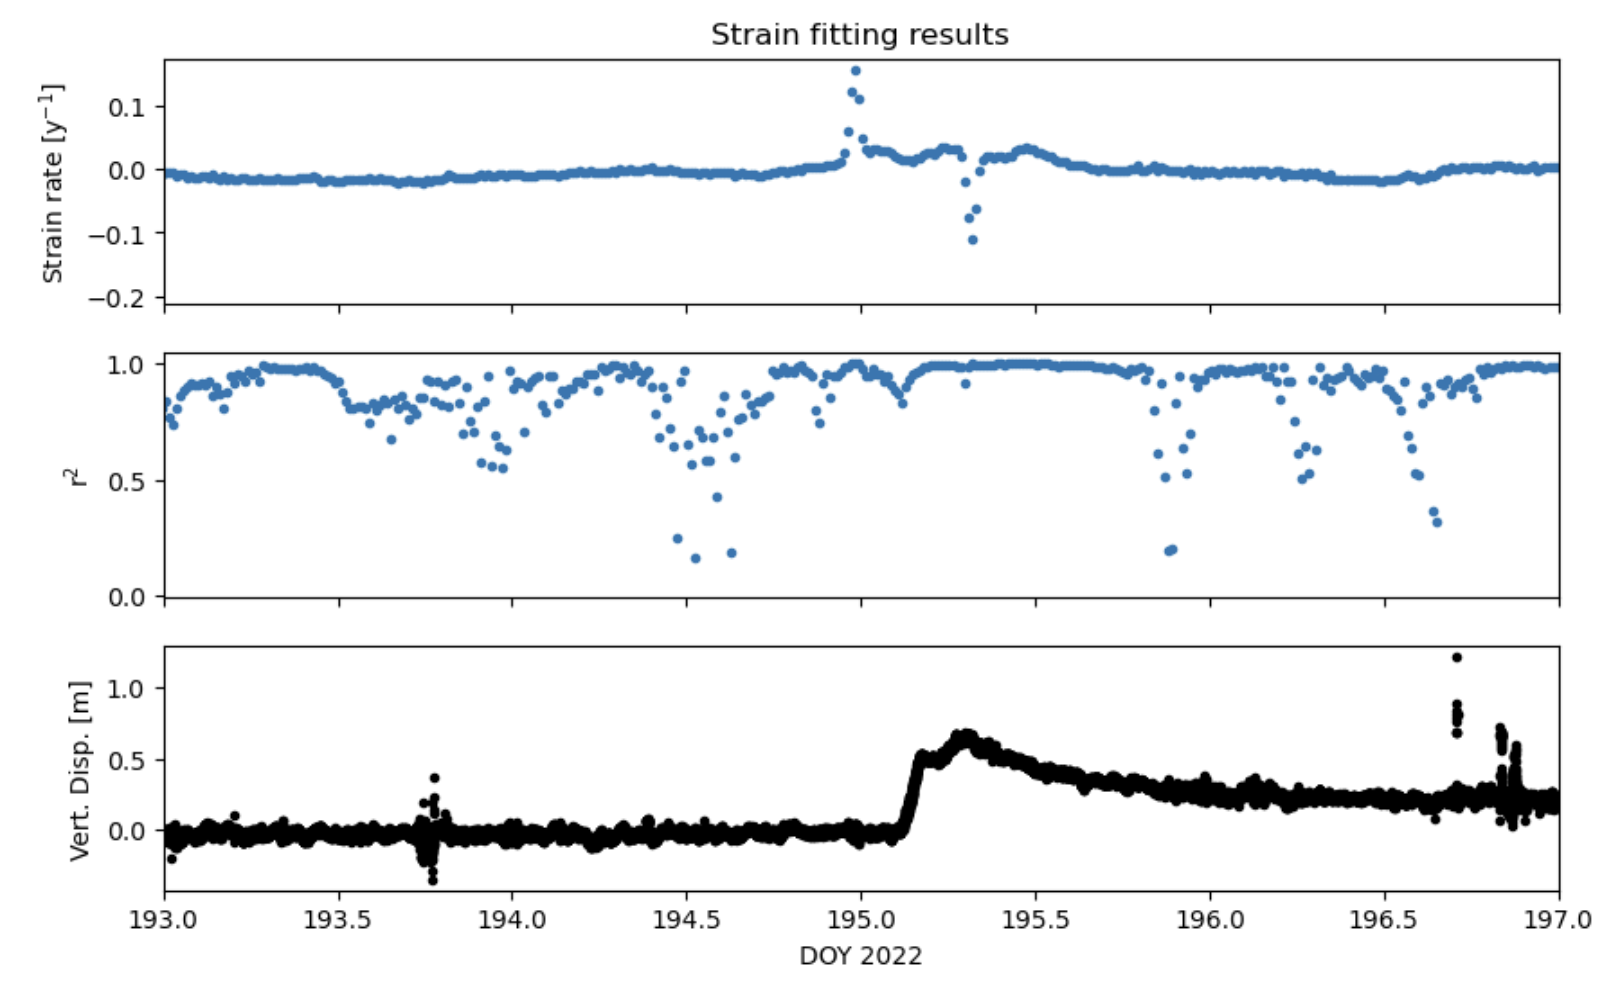